# Microstructure characterization of battery materials based on voxelated image data: Computation of active surface area and tortuosity

## Second validation example: FCC structure

<div class="row">
  <div class="col-md-7" markdown="1">
  This validation increases the complexity of the first example by adding contact between spherical bodies while the volume fraction and surface area can still be expressed analytically as a function of the unit cell side length. This validation is well suited as
<ul>
  <li>the surface is analytically known,</li>
  <li>the example is 3D but yet simple,</li>
  <li>the surface is curved and, thus, will suffer from pixelation issues</li>
  <li>the example can be used to compute tortuosity in the solid and the pore space.</li>
</ul>
<br>
Without a defined overlap, a voxelization issue arises where for all configurations with an even number of voxels per cube length the spheres are touching at voxel edges while for all odd configurations the spheres are fully connected. This can be seen in the front view of the cube:
  </div>
  <div class="col-md-5" markdown="1">
  <img src="data-paper/fcc-study/fcc_solid_3D.png" alt="Image 1" width="220" />
  </div>
</div>
<br>

<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_10_pure.png" alt="2pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_11_pure.png" alt="5pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_50_pure.png" alt="10pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_51_pure.png" alt="20pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_100_pure.png" alt="50pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_101_pure.png" alt="100pixel" width="100" />
</p>


**Author**: Simon Daubner<br>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import taufactor.metrics as tau
import torch
import porespy as ps

import metrics
import data
import time

We initialize the grid resolution as

In [2]:
dx = 1.0

In [3]:
%%capture

fcc_results = {}
overlaps = [0.0,0.01,0.05,0.1]

for overlap in overlaps:
    resolution = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,50,51,100,101,200,201,300,301,400]

    # Initialize fields
    fcc_vol_fraction = {'theo':np.zeros(len(resolution)),
                        'num':np.zeros(len(resolution))}

    methods = ['theo', 'faces', 'marching', 'conv_marching', 'porespy', 'gradient', 'conv_gradient', 'gradient_GPU']
    area = {method: np.zeros(len(resolution)) for method in methods}
    times = {method: np.zeros(len(resolution)) for method in methods[1:]}
    time_CPU_GPU = np.zeros(len(resolution))

    connectivity_type = ['s_side', 's_edge', 's_corner', 'p_side', 'p_edge', 'p_corner']
    connectivity = {conn: np.zeros(len(resolution)) for conn in connectivity_type}
    tortuosity   = {'solid': np.zeros(len(resolution)),
                    'pore': np.zeros(len(resolution))}

    for i, pixels in enumerate(resolution):
        sharp_field = data.create_fcc_cube(pixels, overlap=overlap)
        vol, surf, cap_radius = data.theoretical_fcc_metrics(pixels, overlap)

        fcc_vol_fraction['theo'][i] = vol
        fcc_vol_fraction['num'][i] = metrics.volume_fraction(sharp_field, 1)

        timer=[]
        area['theo'][i] = surf
        timer.append(time.time())
        area['faces'][i] = 3*tau.surface_area(sharp_field, phases=[1]).item()
        timer.append(time.time())
        area['marching'][i] = metrics.specific_surface_area_marching(sharp_field)
        timer.append(time.time())
        phase_field = metrics.smooth_with_convolution(sharp_field)
        area['conv_marching'][i] = metrics.specific_surface_area_marching(phase_field)
        timer.append(time.time())
        area['porespy'][i]  = metrics.specific_surface_area_porespy(sharp_field)
        timer.append(time.time())
        area['gradient'][i] = metrics.specific_surface_area(sharp_field)
        timer.append(time.time())
        area['conv_gradient'][i] = metrics.specific_surface_area(sharp_field, smooth=1)
        timer.append(time.time())

        # Test GPU speed-up using pytorch
        # Separate time measurements for shifting from CPU to GPU and actual computation
        tensor = torch.tensor(sharp_field, dtype=torch.float32)
        tensor = tensor.to('cuda')
        timer.append(time.time())

        grad = torch.gradient(tensor, spacing=(dx,dx,dx))
        norm2 = grad[0].pow(2) + grad[1].pow(2) + grad[2].pow(2)
        surface_area = torch.sum(torch.sqrt(norm2))
        surface_area = surface_area.cpu().item()
        volume = np.prod(sharp_field.shape)
        area['gradient_GPU'][i] = surface_area / volume
        timer.append(time.time())

        for k, method in enumerate(methods[1:]):
            times[method][i] = np.array(timer)[k+1]-np.array(timer)[k]

        time_CPU_GPU[i] = timer[7]-timer[6]
        times['gradient_GPU'][i] = timer[8]-timer[7]

        # Compute through feature and tortuosity
        through_feature, through_fraction = metrics.extract_through_feature(sharp_field, 1, 'x')
        connectivity['s_side'][i] = through_fraction[0]
        connectivity['s_edge'][i] = through_fraction[1]
        connectivity['s_corner'][i] = through_fraction[2]

        if through_fraction[0]>0.0:
            res = metrics.tortuosity(through_feature[0], run_on='cuda')
            if res<1000: tortuosity['solid'][i] = res

        through_feature, through_fraction = metrics.extract_through_feature(sharp_field, 0, 'x')
        connectivity['p_side'][i] = through_fraction[0]
        connectivity['p_edge'][i] = through_fraction[1]
        connectivity['p_corner'][i] = through_fraction[2]

        if through_fraction[0]>0.0:
            res = metrics.tortuosity(through_feature[0], run_on='cuda')
            if res<1000: tortuosity['pore'][i] = res

        # print(f"Finished FCC with {pixels}^3 voxels.")

    fcc_results[f'overlap{int(100*overlap)}'] = {'vol':fcc_vol_fraction,
                                                 'area':area,
                                                 'time':times,
                                                 'connected':connectivity,
                                                 'taufactor':tortuosity}

### Plotting
Plot the results based on following color and line style

In [4]:
colors = ['black', 'red', 'blue', 'purple', 'orange', 'lime', 'green', 'lime', 'orange']
line_styles = ['-', '--', '-.', ':', '--', '-', '-.', ':']

Plot relative volume error

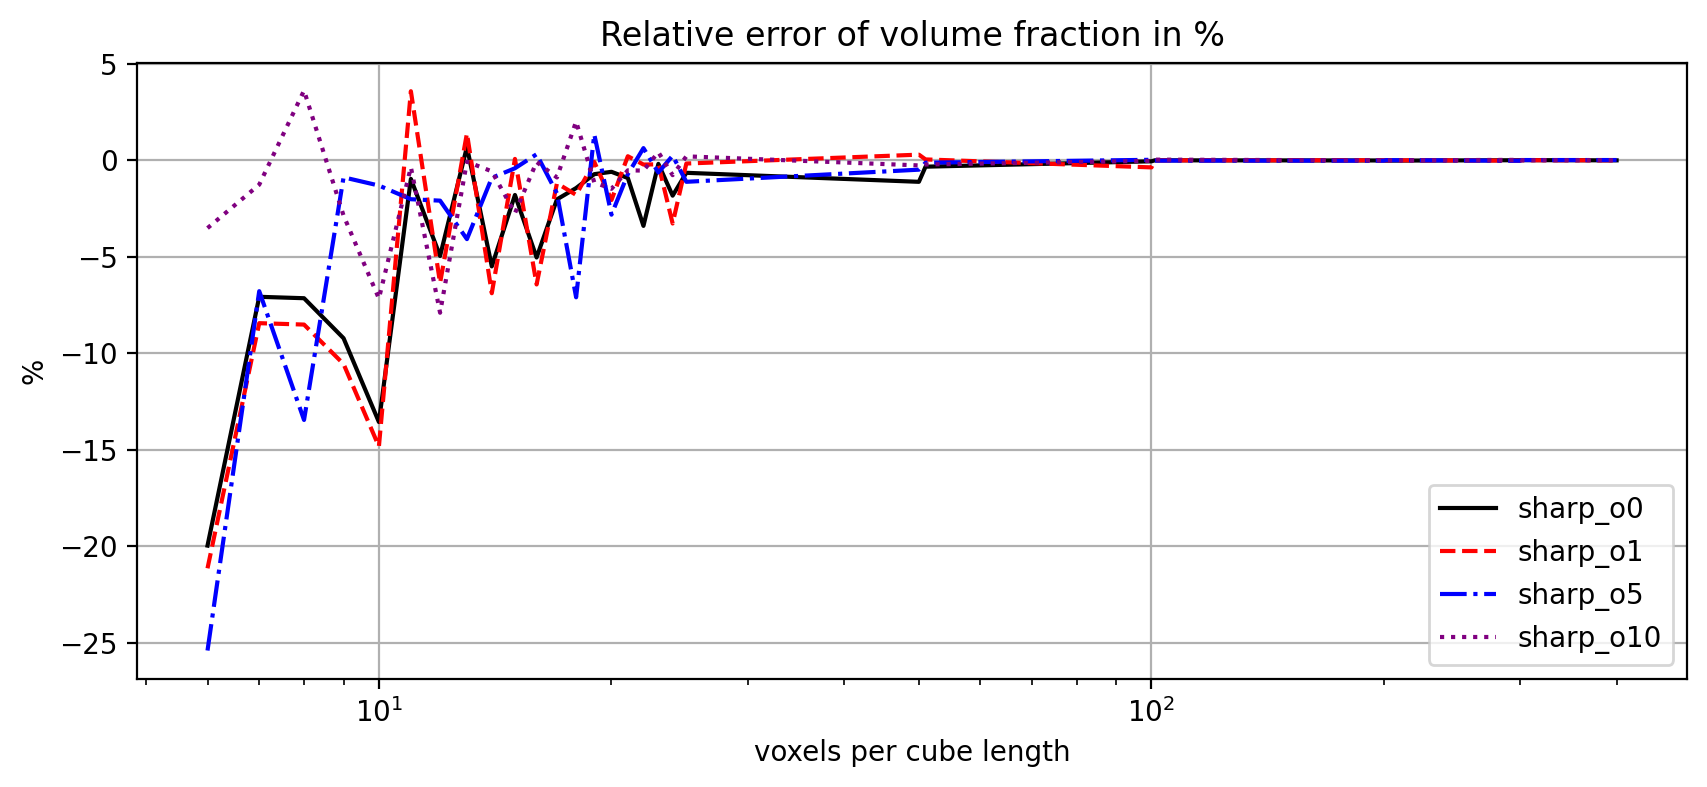

In [5]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
for i, o in enumerate(overlaps):
    ax.semilogx(resolution, (fcc_results[f'overlap{int(100*o)}']['vol']['num']-fcc_results[f'overlap{int(100*o)}']['vol']['theo'])/fcc_results[f'overlap{int(100*o)}']['vol']['theo']*100, label=f'sharp_o{int(100*o)}', color=colors[i], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('%')
ax.set_title('Relative error of volume fraction in %')
ax.legend()
ax.grid()
plt.show()

Relative error of surface area computation

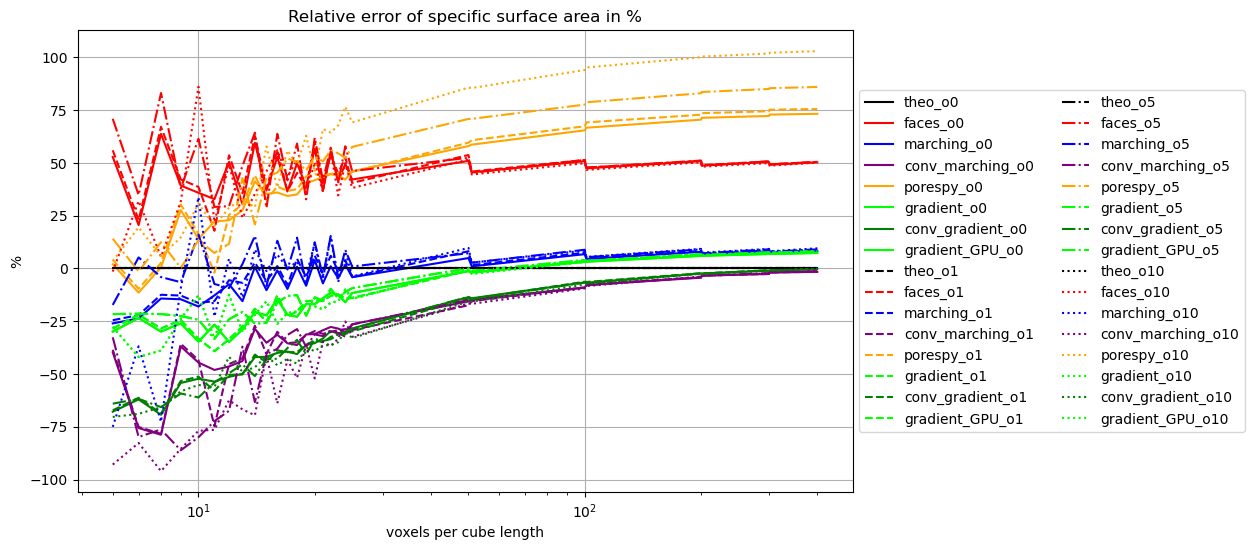

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, o in enumerate(overlaps):
    for j, method in enumerate(methods):
        rel_error = (fcc_results[f'overlap{int(100*o)}']['area'][method]-fcc_results[f'overlap{int(100*o)}']['area']['theo'])/fcc_results[f'overlap{int(100*o)}']['area']['theo']*100
        ax.semilogx(resolution, rel_error, label=method+f'_o{int(100*o)}', color=colors[j], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('%')
ax.set_title('Relative error of specific surface area in %')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
ax.grid()
# plt.ylim(-20, 20)

plt.show()

And, last but not least, the computation times

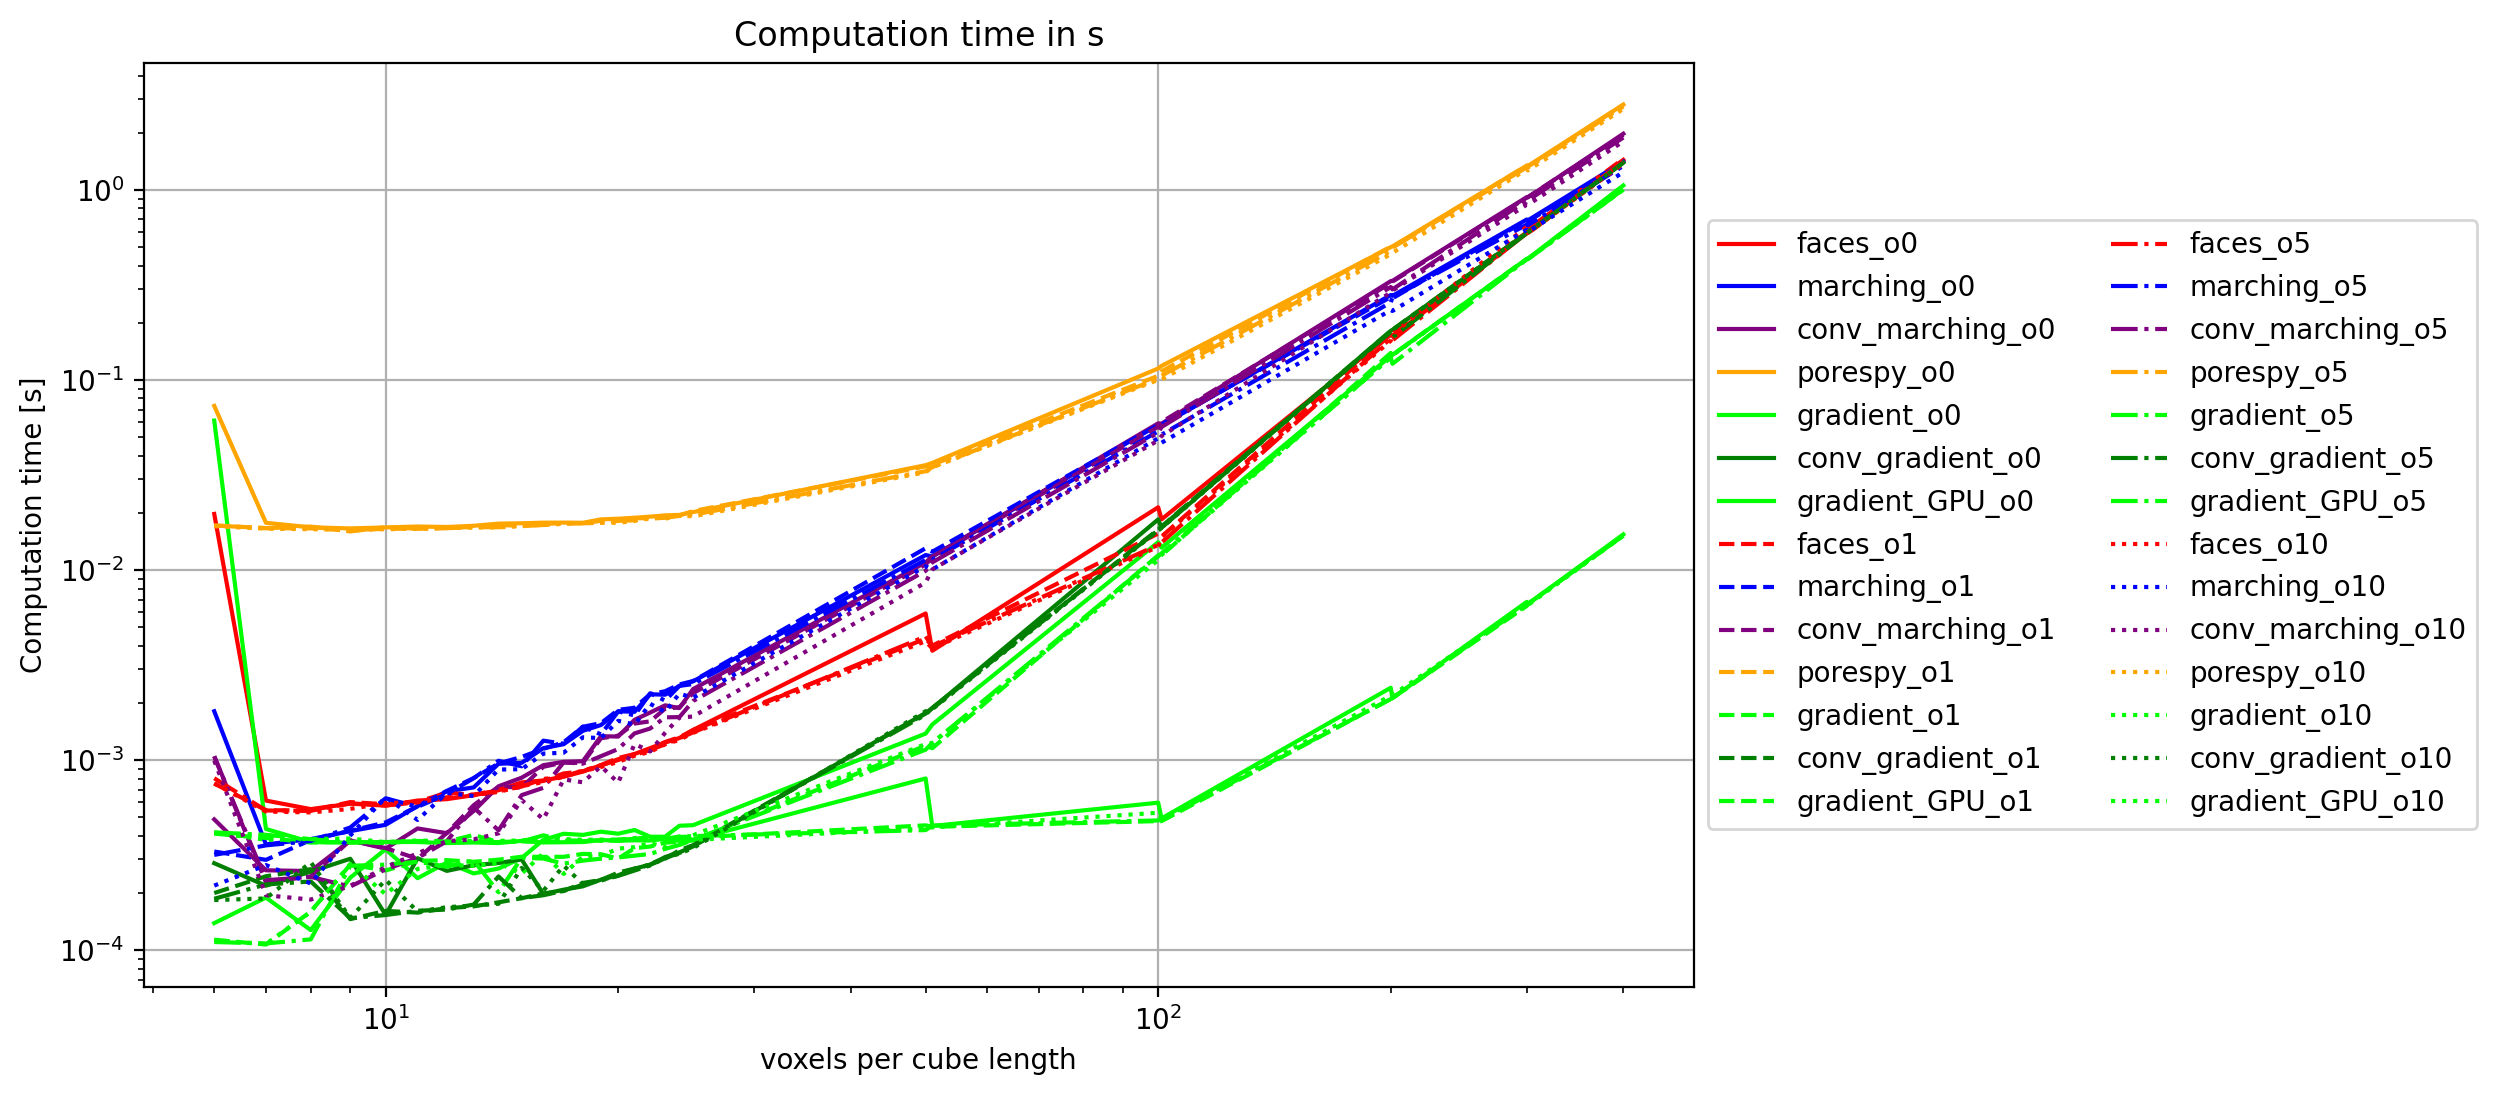

In [7]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
for i, o in enumerate(overlaps):
    for j, method in enumerate(methods[1:]):
        ax.loglog(resolution, fcc_results[f'overlap{int(100*o)}']['time'][method], label=method+f'_o{int(100*o)}', color=colors[j+1], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('Computation time [s]')
ax.set_title('Computation time in s')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
ax.grid()

plt.show()

### Save results to text file
Define a file name and write results dictionary as text table

In [8]:
for o in overlaps:
    file_name = f"fcc_overlap{int(100*o)}.txt"
    output = {'pixels':resolution}
    buffer = fcc_results[f'overlap{int(100*o)}']
    for key,s in buffer['vol'].items():
        header = 'vol_'+key
        output[header] = s
    for key,s in buffer['area'].items():
        header = 'a_'+key
        output[header] = s
    for key,s in buffer['time'].items():
        header = 't_'+key
        output[header] = s
    for key,s in buffer['connected'].items():
        header = 'con_'+key
        output[header] = s
    for key,s in buffer['taufactor'].items():
        header = 'tau_'+key
        output[header] = s

    data.write_dict_to_txt(output, file_name)
    print(f"Data written to {file_name}.")

Data written to fcc_overlap0.txt.
Data written to fcc_overlap1.txt.
Data written to fcc_overlap5.txt.
Data written to fcc_overlap10.txt.
